
# PC4 — Baselines & Feature Engineering (Store 6, Rossmann)

**Objetivo**: construir baselines (Naïve y Media Móvil 7 días), evaluar métricas (MAE, RMSE, R²), detectar incongruencias (`Customers/Open/Sales`), y preparar **features temporales** y **de memoria** para modelos posteriores (p.ej., LSTM con horizonte 30 días).


In [42]:

# =====================
# Configuración general
# =====================
from pathlib import Path

# --- Rutas y parámetros ---
DATA_PATH = Path("data/df_tienda1_preprocesado.csv")  # TODO: ajusta a tu ruta real
DATE_COL = "Date"                             # Nombre de la columna fecha
TARGET_COL = "Sales"                          # Variable objetivo

# División temporal
SPLIT_TRAIN = 0.80
SPLIT_TEST  = 0.10

# Parámetros de baselines
ROLLING_WINDOW = 7

# Flags opcionales
USE_ONE_HOT_FOR_CATEGORICALS = True  # One-Hot vs Label (para categóricas pequeñas)
PRINT_SAMPLE_ROWS = 5

print("Config OK")

Config OK


In [43]:

# ============
# Dependencias
# ============
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

plt.rcParams["figure.figsize"] = (10, 4)  # tamaño estándar para todas las figuras

def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

In [44]:

# ====================
# Carga y preprocesado
# ====================
if not DATA_PATH.exists():
    print(f"AVISO: No se encontró {DATA_PATH}. Ajusta DATA_PATH y vuelve a ejecutar esta celda.")
else:
    df = pd.read_csv(DATA_PATH)
    print("Data loaded:", df.shape)
    # Estandarizar nombres de columnas
    df.columns = [c.strip() for c in df.columns]
    
    # Asegurar columna de fecha
    if DATE_COL not in df.columns:
        raise ValueError(f"No se encuentra columna de fecha '{DATE_COL}' en el dataset.")
    df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
    df = df.sort_values(DATE_COL).reset_index(drop=True)
    
    
    # Asegurar columna objetivo
    if TARGET_COL not in df.columns:
        raise ValueError(f"No se encuentra columna objetivo '{TARGET_COL}'.")
    
    # Vista rápida
    display(df.head(PRINT_SAMPLE_ROWS))

Data loaded: (881, 12)


,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,Customers-1lag
0,2,2013-01-01,0.0,0.0,0,0,0,0,0,1,1,781.0
1,3,2013-01-02,6089.0,781.0,1,0,0,1,1,1,1,689.0
2,4,2013-01-03,5398.0,689.0,1,0,1,1,1,1,1,724.0
3,5,2013-01-04,6092.0,724.0,1,0,1,1,1,1,1,467.0
4,6,2013-01-05,3872.0,467.0,1,0,1,1,1,1,1,0.0


In [45]:

# ===================
# División 80% / 20%
# ===================
def temporal_split(df, date_col, ratio_train=0.80):
    assert 0 < ratio_train < 1, "El ratio debe estar entre 0 y 1."
    n = len(df)
    n_train = int(n * ratio_train)
    train = df.iloc[:n_train].copy()
    test  = df.iloc[n_train:].copy()
    return train, test

if 'df' in globals():
    train, test = temporal_split(df, DATE_COL, ratio_train=SPLIT_TRAIN)
    print("Split sizes:", len(train), len(test))
    print("Train:", train[DATE_COL].min(), "->", train[DATE_COL].max())
    print("Test :", test[DATE_COL].min(), "->", test[DATE_COL].max())

Split sizes: 704 177
Train: 2013-01-01 00:00:00 -> 2014-12-05 00:00:00
Test : 2014-12-06 00:00:00 -> 2015-05-31 00:00:00


In [46]:

# ==================
# Baselines (naïve &
# rolling mean 7 días)
# ==================
def baseline_naive(s):
    # Pred(t) = Real(t-1)
    return s.shift(1)

def baseline_rolling_mean(s, window=7):
    # Pred(t) = media de últimos 'window' días, usando solo pasado
    return s.shift(1).rolling(window=window, min_periods=window).mean()

def evaluate_baselines(df_part, target_col, window=7):
    y = df_part[target_col].astype(float)
    pred_naive = baseline_naive(y)
    pred_roll  = baseline_rolling_mean(y, window=window)
    # Drop NA (por el shift y rolling)
    mask = (~pred_naive.isna()) & (~pred_roll.isna())
    y_true = y[mask]
    p1 = pred_naive[mask]
    p2 = pred_roll[mask]
    metrics = pd.DataFrame({
        "model": ["Baseline Naïve", f"Baseline_RollMean_{window}"],
        "MAE":   [mean_absolute_error(y_true, p1), mean_absolute_error(y_true, p2)],
        "RMSE":  [rmse(y_true, p1), rmse(y_true, p2)],
        "R2":    [r2_score(y_true, p1), r2_score(y_true, p2)]
    })
    return metrics, y_true, p1, p2

if 'df' in globals():
    m_train, ytr, p1tr, p2tr = evaluate_baselines(train, TARGET_COL, window=ROLLING_WINDOW)
    m_test,  yt,  p1t,  p2t  = evaluate_baselines(test,  TARGET_COL, window=ROLLING_WINDOW)
    
    metrics_table = pd.concat([
        m_train.assign(split="train"),
        m_test.assign(split="test"),
    ], ignore_index=True)
    
    display(metrics_table)

,model,MAE,RMSE,R2,split
0,Baseline Naïve,2414.362984,3466.703659,-0.795579,train
1,Baseline_RollMean_7,2006.010248,2615.506733,-0.022075,train
2,Baseline Naïve,2172.147059,3097.813638,-0.756219,test
3,Baseline_RollMean_7,1867.831092,2423.497205,-0.074863,test


# Esta será nuestra primera referencia BASELINE usando el método Naive tenemos un error de 3466 euros en Train y en Test de 3097. R2 SON valores negativos, lo cual significa que los modelos predicen peor que una línea horizontal con la media de ventas.
- El método RollingMedia de 7 días suaviza un poco y reduce un poco el error, pero ambos métodos tienen un fallo importante del rango de 2400 a 3400 euros.

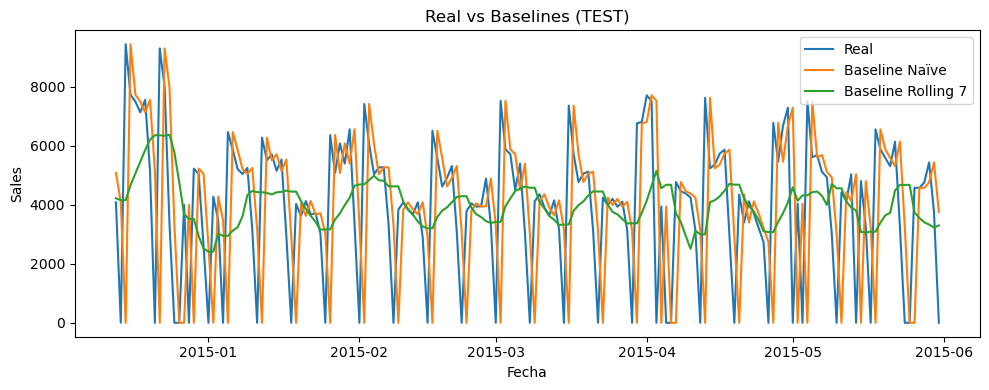

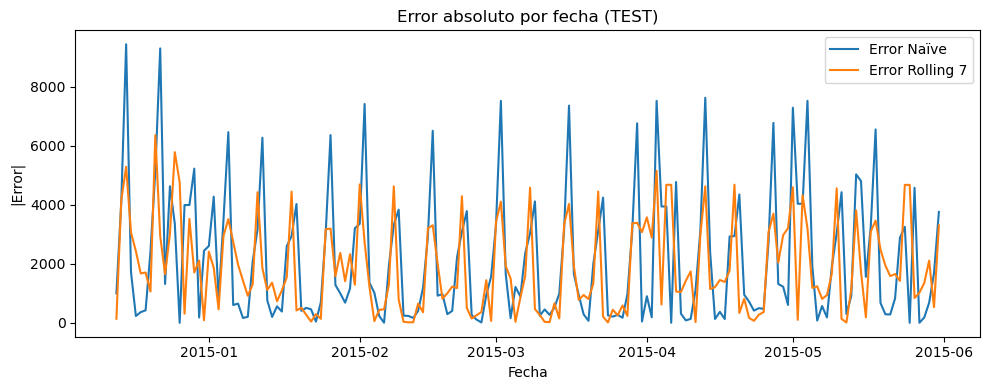

In [48]:

# =========================
# Visualizaciones de baselines
# =========================
def plot_lines(dates, y_true, p1, p2, title="Real vs Baselines (split)"):
    plt.figure()
    plt.plot(dates, y_true, label="Real")
    plt.plot(dates, p1, label="Baseline Naïve")
    plt.plot(dates, p2, label=f"Baseline Rolling {ROLLING_WINDOW}")
    plt.title(title)
    plt.xlabel("Fecha")
    plt.ylabel(TARGET_COL)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_error(dates, y_true, p1, p2, title="Error absoluto por fecha"):
    e1 = (y_true - p1).abs()
    e2 = (y_true - p2).abs()
    plt.figure()
    plt.plot(dates, e1, label="Error Naïve")
    plt.plot(dates, e2, label=f"Error Rolling {ROLLING_WINDOW}")
    plt.title(title)
    plt.xlabel("Fecha")
    plt.ylabel("|Error|")
    plt.legend()
    plt.tight_layout()
    plt.show()

if 'df' in globals():
    # Solo graficamos en TEST (más representativo)
    idx = yt.index                       # índices válidos tras drop por shift/rolling
    dates_test = test.loc[idx, DATE_COL] # <-- usar .loc, no .iloc
    plot_lines(dates_test, yt, p1t, p2t, title="Real vs Baselines (TEST)")
    plot_error(dates_test, yt, p1t, p2t, title="Error absoluto por fecha (TEST)")

## Conclusiones de Naive y Rolling

* Gráfica superior (Real vs Baselines):
  
- El Naïve (naranja) sigue muy de cerca los picos y valles del real (azul), pero es muy errático.
- El Rolling Mean (verde) suaviza demasiado → pierde reactividad ante cambios bruscos, pero logra capturar la tendencia.
* Gráfica inferior (Error absoluto por fecha):

- El Naïve tiene errores altos en días con cambios fuertes (los picos azules grandes).
- El Rolling Mean (naranja) reduce la magnitud de los errores en general, aunque se queda rezagado cuando hay cambios rápidos.
  
* El patrón es claro: Naïve reacciona rápido pero se equivoca mucho en días extremos; Rolling Mean es más estable pero tarda en adaptarse.
- El Naïve reproduce muy bien la forma de la serie pero con errores grandes.
- El Rolling Mean reduce el error medio pero a costa de reaccionar lento.
- Ninguno de los dos es “suficiente” (R² < 0). Son referencias útiles para justificar la necesidad de un modelo más avanzado (ARIMA, LSTM, etc.).

# Revisión de congruencia de variables Customer, Open y Sales

In [9]:

# ==========================================================
# Chequeo de incongruencias: Customers / Open / Sales
# ==========================================================
def check_incongruences(df, cols=("Customers", "Open", "Sales")):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        print("No se pudieron verificar incongruencias. Faltan columnas:", missing)
        return None
    sub = df[list(cols)].copy()
    # Casos
    case1 = (sub["Customers"] == 0) & (sub["Open"] == 0) & (sub["Sales"] == 0)  # Lógico
    case2 = (sub["Customers"] == 0) & (sub["Open"] == 1) & (sub["Sales"] == 0)  # Raro
    case3 = (sub["Customers"] >  0) & (sub["Open"] == 1) & (sub["Sales"] == 0)  # Raro
    
    counts = {
        "C=0,O=0,S=0 (lógico)": int(case1.sum()),
        "C=0,O=1,S=0 (raro)":   int(case2.sum()),
        "C>0,O=1,S=0 (raro)":   int(case3.sum())
    }
    counts_df = pd.DataFrame.from_dict(counts, orient="index", columns=["n_registros"])
    return counts_df, df[case2 | case3].head(10)  # muestra de raros

if 'df' in globals():
    res = check_incongruences(df, cols=("Customers","Open","Sales"))
    if res is not None:
        counts_df, rare_sample = res
        display(counts_df)
        if not rare_sample.empty:
            print("Muestra de casos raros:")
            display(rare_sample.head(PRINT_SAMPLE_ROWS))

,n_registros
"C=0,O=0,S=0 (lógico)",154
"C=0,O=1,S=0 (raro)",0
"C>0,O=1,S=0 (raro)",0


## Siempre venden algo y no hay incongruencias en los días de apertura, clientes y ventas.

# Creación de variables de fecha y categóricas

In [59]:

# =============================================
# Feature Engineering (Parte 1): Variables de fecha
# y categóricas (con codificación adecuada)
# =============================================
# ----------------------------------------
# Creación de función que recibe df y nuevas columnas de fechas
# ------------

def add_date_features(df, date_col):
    """
    Añade variables de fecha derivadas de la columna DATE_COL.
    No produce leakage (solo usa la fecha conocida).
    """
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])

    # Variables de calendario
    df["year"] = df[date_col].dt.year
    df["month"] = df[date_col].dt.month
    df["day"] = df[date_col].dt.day
    df["dayofweek"] = df[date_col].dt.dayofweek  # lunes=0
    df["weekofyear"] = df[date_col].dt.isocalendar().week.astype(int)
    df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)

    # Codificación cíclica para mes y día de la semana
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)
    df["dow_sin"] = np.sin(2 * np.pi * df["dayofweek"] / 7)
    df["dow_cos"] = np.cos(2 * np.pi * df["dayofweek"] / 7)

    return df


# 1) FE de fecha (no produce leakage) y split temporal 80/20
df_fe = add_date_features(df, DATE_COL)

train_fe, test_fe = temporal_split(df_fe, DATE_COL, ratio_train=SPLIT_TRAIN)

# 2) Categóricas a codificar (ajusta a tu dataset)
categorical_cols = ["Promo", "StateHoliday", "SchoolHoliday", "Open"]

def ohe_no_leak(train_df, test_df, cat_cols, drop_first=False):
    """
    One-Hot sin leakage:
      - aprende columnas dummies SOLO con train
      - aplica a test reindexando a las columnas de train
    """
    tr = train_df.copy()
    te = test_df.copy()

    # 1) Categóricas realmente presentes en TRAIN
    cat_cols_tr = [c for c in cat_cols if c in tr.columns]
    if not cat_cols_tr:
        print("Aviso: ninguna columna categórica de", cat_cols, "está en TRAIN.")
        return tr, te, []

    # 2) Garantizar que TEST tenga esas columnas (si falta alguna, la creamos)
    for c in cat_cols_tr:
        if c not in te.columns:
            te[c] = np.nan

    # 3) Tipos homogéneos (NaN -> "nan" al convertir a str)
    tr[cat_cols_tr] = tr[cat_cols_tr].astype(str)
    te[cat_cols_tr] = te[cat_cols_tr].astype(str)

    # 4) Ajuste OHE en TRAIN y transformación en TEST
    tr_ohe = pd.get_dummies(tr[cat_cols_tr], drop_first=drop_first)
    te_ohe = pd.get_dummies(te[cat_cols_tr], drop_first=drop_first)
    te_ohe = te_ohe.reindex(columns=tr_ohe.columns, fill_value=0)

    # 5) Concatenar y eliminar originales (ignorando si no están)
    tr = pd.concat([tr.drop(columns=cat_cols_tr, errors="ignore"), tr_ohe], axis=1)
    te = pd.concat([te.drop(columns=cat_cols_tr, errors="ignore"), te_ohe], axis=1)

    return tr, te, tr_ohe.columns


In [61]:

# =============================================
# Feature Engineering (Parte 2): Lags & Rolling
# =============================================
def add_lags_and_rolling(df, target_col, lags=(1,7), roll_means=(7,30), roll_std=(7,)):
    out = df.copy()
    # Lags del target
    for L in lags:
        out[f"{target_col}_lag{L}"] = out[target_col].shift(L)
    # Rolling means (shift para evitar leakage)
    for w in roll_means:
        out[f"{target_col}_mean_{w}"] = out[target_col].shift(1).rolling(window=w, min_periods=w).mean()
    # Rolling std
    for w in roll_std:
        out[f"{target_col}_std_{w}"] = out[target_col].shift(1).rolling(window=w, min_periods=w).std()
    return out

def add_customers_memory(df):
    out = df.copy()
    if "Customers" in out.columns:
        out["Customers_lag1"] = out["Customers"].shift(1)
        out["Customers_ma7"]  = out["Customers"].shift(1).rolling(window=7, min_periods=7).mean()
    else:
        print("AVISO: no se agregó memoria de Customers; columna 'Customers' no existe.")
    return out

if 'df_fe' in globals():
    df_fe2 = add_lags_and_rolling(df_fe, TARGET_COL, lags=(1,7), roll_means=(7,30), roll_std=(7,))
    df_fe2 = add_customers_memory(df_fe2)
    # Drop NA generados por lags/rolling
    before = df_fe2.shape[0]
    df_fe2 = df_fe2.dropna().reset_index(drop=True)
    after = df_fe2.shape[0]
    print(f"FE Parte 2 OK. Drop por lags/rolling: {before} -> {after}")
    display(df_fe2.head(PRINT_SAMPLE_ROWS))

FE Parte 2 OK. Drop por lags/rolling: 881 -> 850


,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,StateHoliday_b,...,month_cos,dow_sin,dow_cos,Sales_lag1,Sales_lag7,Sales_mean_7,Sales_mean_30,Sales_std_7,Customers_lag1,Customers_ma7
0,4,2013-01-31,6458.0,755.0,1,0,1,1,1,1,...,0.866025,0.433884,-0.900969,5751.0,5844.0,4727.285714,4860.233333,2304.490740,708.0,561.857143
1,5,2013-02-01,6601.0,786.0,1,0,1,1,1,1,...,0.500000,-0.433884,-0.900969,6458.0,6433.0,4815.000000,5075.500000,2364.971106,755.0,572.857143
2,6,2013-02-02,3927.0,425.0,1,0,1,1,1,1,...,0.500000,-0.974928,-0.222521,6601.0,3443.0,4839.000000,5092.566667,2384.895875,786.0,578.571429
3,7,2013-02-03,0.0,0.0,0,0,1,1,1,1,...,0.500000,-0.781831,0.623490,3927.0,0.0,4908.142857,5043.533333,2344.348981,425.0,583.857143
4,1,2013-02-04,7954.0,898.0,1,1,0,1,1,1,...,0.500000,0.000000,1.000000,0.0,6209.0,4908.142857,4840.466667,2344.348981,0.0,583.857143


In [67]:

# =============================================
# Exploración de features
#  - Correlación con Sales
#  - Modelo Lineal y RandomForest para importancia
# =============================================
def numeric_features(df):
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    return num_cols

if 'df_fe2' in globals():
    num_cols = numeric_features(df_fe2)
    if TARGET_COL in num_cols:
        corr = df_fe2[num_cols].corr()[TARGET_COL].sort_values(ascending=False)
        print("Correlación (Pearson) con Sales:")
        display(corr.to_frame("corr_with_Sales").head(20))
        display(corr.to_frame("corr_with_Sales").tail(20))
    else:
        print(f"No se encontró {TARGET_COL} entre las columnas numéricas.")
        
    # Split re-hecho tras FE (respetando orden temporal)
    n = len(df_fe2)
    n_train = int(n * SPLIT_TRAIN)
    df_tr = df_fe2.iloc[:n_train].copy()
    df_te = df_fe2.iloc[n_train:].copy()
    
    # Features = todas menos fecha y target "futuro"
    drop_cols = [DATE_COL]
    X_cols = [c for c in df_fe2.columns if c not in drop_cols + [TARGET_COL]]
    
    Xtr, ytr = df_tr[X_cols], df_tr[TARGET_COL]
    Xte, yte = df_te[X_cols], df_te[TARGET_COL]
    
    # Modelo Lineal
    lin = LinearRegression()
    lin.fit(Xtr, ytr)
    yte_pred_lin = lin.predict(Xte)
    print("LinearRegression - Test MAE/RMSE:",
          mean_absolute_error(yte, yte_pred_lin), rmse(yte, yte_pred_lin))
    # Importancias (coeficientes absolutos)
    coefs = pd.Series(np.abs(lin.coef_), index=X_cols).sort_values(ascending=False).head(20)
    print("Top 20 features por |coef| (Lineal):")
    display(coefs.to_frame("abs_coef"))
    
    # RandomForest (robusto para importancia)
    rf = RandomForestRegressor(n_estimators=200, random_state=123, n_jobs=-1)
    rf.fit(Xtr, ytr)
    yte_pred_rf = rf.predict(Xte)
    print("RandomForest - Test MAE/RMSE:",
          mean_absolute_error(yte, yte_pred_rf), rmse(yte, yte_pred_rf))
    imps = pd.Series(rf.feature_importances_, index=X_cols).sort_values(ascending=False).head(20)
    print("Top 20 features por importancia (RF):")
    display(imps.to_frame("importance"))

Correlación (Pearson) con Sales:


,corr_with_Sales
Sales,1.000000
Customers,0.986668
Open,0.824930
Sales_lag7,0.636845
Promo,0.599704
dow_sin,0.499875
StateHoliday_0,0.307845
StateHoliday_a,0.235049
Customers_ma7,0.159019
Sales_mean_30,0.155747


,corr_with_Sales
Customers_ma7,0.159019
Sales_mean_30,0.155747
StateHoliday_b,0.151481
Sales_mean_7,0.142849
Sales_std_7,0.136698
StateHoliday_c,0.123538
Sales_lag1,0.112075
weekofyear,0.103572
Customers-1lag,0.096694
month,0.095264


LinearRegression - Test MAE/RMSE: 219.54417221966912 296.4673803308606
Top 20 features por |coef| (Lineal):


,abs_coef
dayofweek,6.640377e+11
DayOfWeek,6.640377e+11
Open,6.013472e+02
is_weekend,4.977069e+02
Promo,4.433272e+02
StateHoliday_0,2.901415e+02
StateHoliday_b,1.830522e+02
year,1.441935e+02
month_sin,1.101149e+02
StateHoliday_a,7.811188e+01


RandomForest - Test MAE/RMSE: 248.93891176470584 378.6442320435542
Top 20 features por importancia (RF):


,importance
Customers,0.953080
Open,0.028075
Promo,0.003973
dow_sin,0.002797
Sales_lag1,0.002343
Sales_mean_30,0.001225
Sales_lag7,0.001061
weekofyear,0.000901
Customers-1lag,0.000855
Customers_ma7,0.000829


In [69]:
# =============================================
# Exploración de features
#  - Correlación con Sales
#  - Modelo Lineal y RandomForest para importancia
#  - Guardar MAE, RMSE, R2 en metrics_table
# =============================================
def numeric_features(df):
    return df.select_dtypes(include=[np.number]).columns.tolist()

def add_metrics_row(metrics_df, model_name, y_true, y_pred, split_label="test"):
    row = pd.DataFrame([{
        "model": model_name,
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": rmse(y_true, y_pred),
        "R2": r2_score(y_true, y_pred),
        "split": split_label
    }])
    return pd.concat([metrics_df, row], ignore_index=True)

if 'df_fe2' in globals():
    # --- Correlación con Sales ---
    num_cols = numeric_features(df_fe2)
    if TARGET_COL in num_cols:
        corr = df_fe2[num_cols].corr()[TARGET_COL].sort_values(ascending=False)
        print("Correlación (Pearson) con Sales:")
        display(corr.to_frame("corr_with_Sales").head(20))
        display(corr.to_frame("corr_with_Sales").tail(20))
    else:
        print(f"No se encontró {TARGET_COL} entre las columnas numéricas.")

    # --- Split re-hecho tras FE (solo TRAIN/TEST, respetando orden temporal) ---
    n = len(df_fe2)
    n_train = int(n * SPLIT_TRAIN)
    df_tr = df_fe2.iloc[:n_train].copy()
    df_te = df_fe2.iloc[n_train:].copy()

    # --- Selección de features ---
    drop_cols = [DATE_COL]
    X_cols = [c for c in df_fe2.columns if c not in drop_cols + [TARGET_COL]]

    Xtr, ytr = df_tr[X_cols], df_tr[TARGET_COL]
    Xte, yte = df_te[X_cols], df_te[TARGET_COL]

    # Asegurar que existe metrics_table y con columnas consistentes
    if 'metrics_table' not in globals():
        metrics_table = pd.DataFrame(columns=["model", "MAE", "RMSE", "R2", "split"])

    # --- Modelo Lineal ---
    lin = LinearRegression()
    lin.fit(Xtr, ytr)
    yte_pred_lin = lin.predict(Xte)
    print("LinearRegression - Test MAE/RMSE/R2:",
          mean_absolute_error(yte, yte_pred_lin),
          rmse(yte, yte_pred_lin),
          r2_score(yte, yte_pred_lin))

    # Guardar métricas en la tabla
    metrics_table = add_metrics_row(metrics_table, "LinearRegression", yte, yte_pred_lin, split_label="test")

    # Importancias (coeficientes absolutos)
    coefs = pd.Series(np.abs(lin.coef_), index=X_cols).sort_values(ascending=False).head(20)
    print("Top 20 features por |coef| (Lineal):")
    display(coefs.to_frame("abs_coef"))

    # --- RandomForest (robusto para importancia) ---
    rf = RandomForestRegressor(n_estimators=200, random_state=123, n_jobs=-1)
    rf.fit(Xtr, ytr)
    yte_pred_rf = rf.predict(Xte)
    print("RandomForest - Test MAE/RMSE/R2:",
          mean_absolute_error(yte, yte_pred_rf),
          rmse(yte, yte_pred_rf),
          r2_score(yte, yte_pred_rf))

    # Guardar métricas en la tabla
    metrics_table = add_metrics_row(metrics_table, "RandomForest", yte, yte_pred_rf, split_label="test")

    # Importancias
    imps = pd.Series(rf.feature_importances_, index=X_cols).sort_values(ascending=False).head(20)
    print("Top 20 features por importancia (RF):")
    display(imps.to_frame("importance"))

    # Mostrar tabla consolidada
    print("Tabla de métricas actualizada:")
    display(metrics_table)


Correlación (Pearson) con Sales:


,corr_with_Sales
Sales,1.000000
Customers,0.986668
Open,0.824930
Sales_lag7,0.636845
Promo,0.599704
dow_sin,0.499875
StateHoliday_0,0.307845
StateHoliday_a,0.235049
Customers_ma7,0.159019
Sales_mean_30,0.155747


,corr_with_Sales
Customers_ma7,0.159019
Sales_mean_30,0.155747
StateHoliday_b,0.151481
Sales_mean_7,0.142849
Sales_std_7,0.136698
StateHoliday_c,0.123538
Sales_lag1,0.112075
weekofyear,0.103572
Customers-1lag,0.096694
month,0.095264


LinearRegression - Test MAE/RMSE/R2: 219.54417221966912 296.4673803308606 0.9836541637976771
Top 20 features por |coef| (Lineal):


,abs_coef
dayofweek,6.640377e+11
DayOfWeek,6.640377e+11
Open,6.013472e+02
is_weekend,4.977069e+02
Promo,4.433272e+02
StateHoliday_0,2.901415e+02
StateHoliday_b,1.830522e+02
year,1.441935e+02
month_sin,1.101149e+02
StateHoliday_a,7.811188e+01


RandomForest - Test MAE/RMSE/R2: 248.93891176470584 378.6442320435542 0.9733365708943383
Top 20 features por importancia (RF):


,importance
Customers,0.953080
Open,0.028075
Promo,0.003973
dow_sin,0.002797
Sales_lag1,0.002343
Sales_mean_30,0.001225
Sales_lag7,0.001061
weekofyear,0.000901
Customers-1lag,0.000855
Customers_ma7,0.000829


Tabla de métricas actualizada:


,model,MAE,RMSE,R2,split
0,Baseline Naïve,2414.362984,3466.703659,-0.795579,train
1,Baseline_RollMean_7,2006.010248,2615.506733,-0.022075,train
2,Baseline Naïve,2172.147059,3097.813638,-0.756219,test
3,Baseline_RollMean_7,1867.831092,2423.497205,-0.074863,test
4,LinearRegression,219.544172,296.467380,0.983654,test
5,RandomForest,248.938912,378.644232,0.973337,test



## Conclusiones (para completar tras ejecutar)
- Comparación de **Baseline Naïve** vs **Rolling Mean 7 días** vs **LinearRegresion** vs **RandomForest**   tenemos mejoras significativas con respecto el error medio y la cuadrático con estos nuevos algoritmos y la R2 es altísimo en LR y RF, esto quiere decir que los modelos explican el 98% de la variación de las ventas. Estas variables y las Ventas tienen una buena correlación. El RF no aporta mucho más que la RegresionLineal.
- Valor añadido de **features temporales** y **de memoria** (correlación + importancias), se han creado y más adelante evaluaremos si realmente aportan al LSTM

Guardamos el df_fe (datos originales mas todas las nuevas variables creadas)


In [85]:
# =============================================
# Guardado de DataFrames principales a CSV
# =============================================

# 1) Guardar dataset con features
df_fe.to_csv("data/df_fe.csv", index=False)
print("Guardado df_fe.csv con shape:", df_fe.shape)

# 2) Guardar tabla de métricas
metrics_table.to_csv("metrics_table.csv", index=False)
print("Guardado metrics_table.csv con shape:", metrics_table.shape)


Guardado df_fe.csv con shape: (881, 22)
Guardado metrics_table.csv con shape: (6, 5)


In [79]:
df_fe.head().T

,0,1,2,3,4
DayOfWeek,2,3,4,5,6
Date,2013-01-01 00:00:00,2013-01-02 00:00:00,2013-01-03 00:00:00,2013-01-04 00:00:00,2013-01-05 00:00:00
Sales,0.0,6089.0,5398.0,6092.0,3872.0
Customers,0.0,781.0,689.0,724.0,467.0
Open,0,1,1,1,1
Promo,0,0,0,0,0
SchoolHoliday,0,0,1,1,1
StateHoliday_0,0,1,1,1,1
StateHoliday_a,0,1,1,1,1
StateHoliday_b,1,1,1,1,1
